In [3]:
import pandas as pd
import numpy as np
import itertools
import tensorflow
import tensorflow.keras as keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import math
import datetime
import time

In [4]:
img_width, img_height = 224, 224  
   
#Create a bottleneck file
top_model_weights_path = 'bottleneck_fc_model.h5' 

# loading up our datasets
train_data_dir = 'data/train'  
validation_data_dir = 'data/validation'  
test_data_dir = 'data/test'
   
# number of epochs to train top model  
epochs = 7 #this has been changed after multiple model run  
# batch size used by flow_from_directory and predict_generator  
batch_size = 50  

In [5]:
vgg16 = applications.VGG16(include_top=False, weights='imagenet') 

Metal device set to: Apple M1


In [6]:
datagen = ImageDataGenerator(rescale=1. / 255)

In [8]:
start = datetime.datetime.now()

datagen = ImageDataGenerator(rescale=1. / 255)  # You might need to adjust the preprocessing steps

generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

nb_train_samples = len(generator.filenames)
num_classes = len(generator.class_indices)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))

bottleneck_features_train = vgg16.predict(generator, steps=predict_size_train)

np.save('bottleneck_features_train.npy', bottleneck_features_train)

end = datetime.datetime.now()
elapsed = end - start
print('Time:', elapsed)

Found 13412 images belonging to 6 classes.
269/269 [==============================] - 267s 995ms/step
Time: 0:04:30.734989


In [12]:
print('-'*117)

---------------------------------------------------------------------------------------------------------------------


In [14]:
start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = vgg16.predict(  
     generator, predict_size_validation)  
   
np.save('bottleneck_features_validation.npy', bottleneck_features_validation) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)
print('-'*117)

Found 2549 images belonging to 6 classes.
51/51 [==============================] - 46s 924ms/step
Time:  0:00:47.798183
---------------------------------------------------------------------------------------------------------------------


In [16]:
start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     test_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_test_samples = len(generator.filenames)  
   
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
   
bottleneck_features_test = vgg16.predict(  
     generator, predict_size_test)  
   
np.save('bottleneck_features_test.npy', bottleneck_features_test) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 1845 images belonging to 6 classes.
37/37 [==============================] - 34s 940ms/step
Time:  0:00:35.441574


In [17]:
generator_top = datagen.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train.npy')  
   
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes) 

Found 13412 images belonging to 6 classes.


In [18]:
generator_top = datagen.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation.npy')  
   

validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)  

Found 2549 images belonging to 6 classes.


In [19]:
generator_top = datagen.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('bottleneck_features_test.npy')  
   

test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 1845 images belonging to 6 classes.


In [21]:
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.5))  
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))  

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])  

history = model.fit(train_data, train_labels,  
      epochs=7,
      batch_size=batch_size,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)


Epoch 1/7
269/269 [==============================] - 8s 28ms/step - loss: 0.7058 - acc: 0.7543 - val_loss: 0.3616 - val_acc: 0.8843
Epoch 2/7
269/269 [==============================] - 7s 26ms/step - loss: 0.3824 - acc: 0.8750 - val_loss: 0.3867 - val_acc: 0.8745
Epoch 3/7
269/269 [==============================] - 7s 26ms/step - loss: 0.2990 - acc: 0.8996 - val_loss: 0.3180 - val_acc: 0.8902
Epoch 4/7
269/269 [==============================] - 7s 26ms/step - loss: 0.2441 - acc: 0.9186 - val_loss: 0.3173 - val_acc: 0.8992
Epoch 5/7
269/269 [==============================] - 7s 26ms/step - loss: 0.2038 - acc: 0.9318 - val_loss: 0.2719 - val_acc: 0.9129
Epoch 6/7
269/269 [==============================] - 7s 26ms/step - loss: 0.1820 - acc: 0.9439 - val_loss: 0.3126 - val_acc: 0.9058
Epoch 7/7
51/51 [==============================] - 1s 14ms/step - loss: 0.3114 - acc: 0.9047
[INFO] accuracy: 90.47%
[INFO] Loss: 0.31137147545814514
Time:  0:00:51.692771


In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 100)               2508900   
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 50)                5050      
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 6)                 306       
                                                                 
Total params: 2,514,256
Trainable params: 2,514,256
No

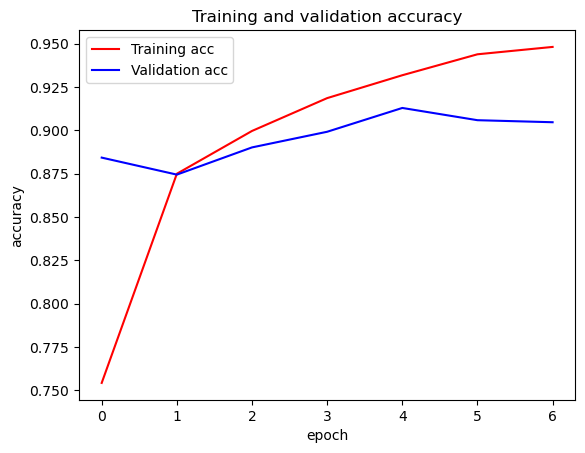

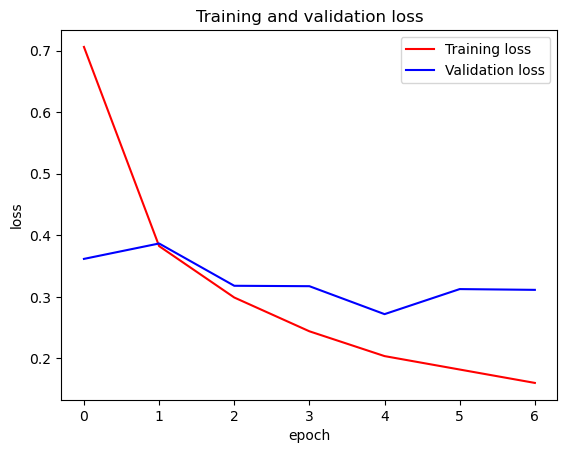

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

In [24]:
model.evaluate(test_data, test_labels)

58/58 [==============================] - 1s 12ms/step - loss: 0.3230 - acc: 0.9041


[0.3229793608188629, 0.9040650129318237]

In [25]:
print('test data', test_data)
preds = np.round(model.predict(test_data),0) 
#to fit them into classification metrics and confusion metrics, some additional modificaitions are required
print('rounded test_labels', preds)

test data [[[[1.59661397e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    7.54971504e-01 0.00000000e+00]
   [9.25386697e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    6.20073259e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    4.85158384e-01 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    4.90490764e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    4.19419318e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    5.66730857e-01 0.00000000e+00]]

  [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    5.70549548e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 2.11467564e-01 ... 0.00000000e+00
    3.43592823e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 6.56663001e-01 ... 0.00000000e+00
    1.32428706e-01 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 4.17726576e-0

In [26]:
animals = ['butterflies', 'chickens', 'elephants', 'horses', 'spiders', 'squirells']
classification_metrics = metrics.classification_report(test_labels, preds, target_names=animals )
print(classification_metrics)

              precision    recall  f1-score   support

 butterflies       1.00      0.81      0.89       371
    chickens       0.82      0.90      0.86       203
   elephants       0.93      0.86      0.89       152
      horses       0.96      0.95      0.96       472
     spiders       0.82      0.99      0.90       403
   squirells       0.97      0.79      0.87       244

   micro avg       0.91      0.90      0.90      1845
   macro avg       0.92      0.88      0.90      1845
weighted avg       0.92      0.90      0.90      1845
 samples avg       0.90      0.90      0.90      1845



/Users/ayushkumar/anaconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)
confusion_matrix= confusion_matrix(categorical_test_labels, categorical_preds)

In [28]:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
#     print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


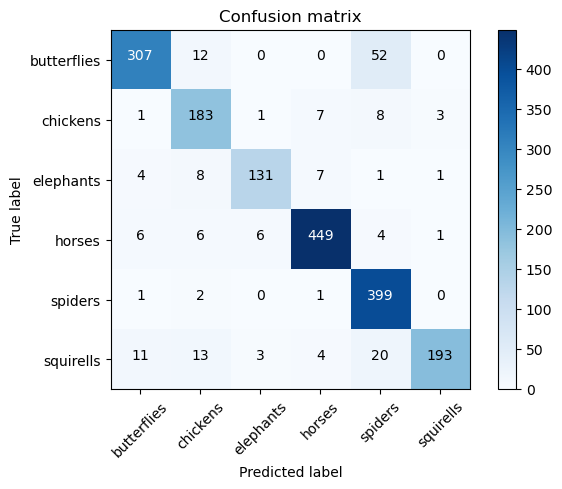

In [29]:
plot_confusion_matrix(confusion_matrix, ['butterflies', 'chickens', 'elephants', 'horses', 'spiders', 'squirells'])


Normalized confusion matrix


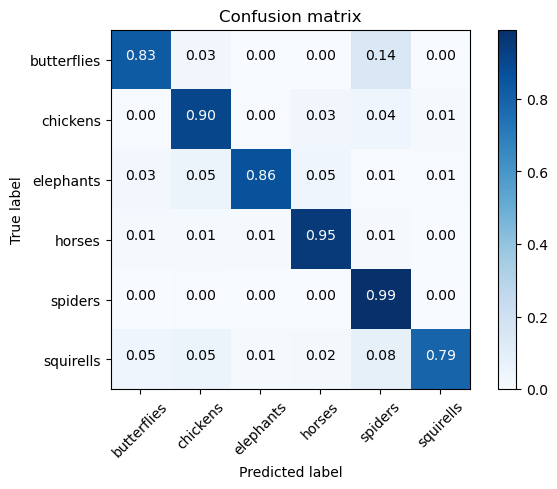

In [30]:
plot_confusion_matrix(confusion_matrix, 
                      ['butterflies', 'chickens', 'elephants', 'horses', 'spiders', 'squirells'],
                     normalize=True)

In [31]:
def read_image(file_path):
    print("[INFO] loading and preprocessing image...")  
    image = load_img(file_path, target_size=(224, 224))  
    image = img_to_array(image)  
    image = np.expand_dims(image, axis=0)
    image /= 255.  
    return image

[INFO] loading and preprocessing image...
1/1 [==============================] - 0s 11ms/step
ID: 0, Label: butterflies 0.0%
ID: 1, Label: chickens 0.01%
ID: 2, Label: elephants 99.91%
ID: 3, Label: horses 0.05%
ID: 4, Label: spiders 0.01%
ID: 5, Label: squirells 0.02%
Final Decision:
.
..
...
1/1 [==============================] - 0s 18ms/step
ID: 2, Label: elephants


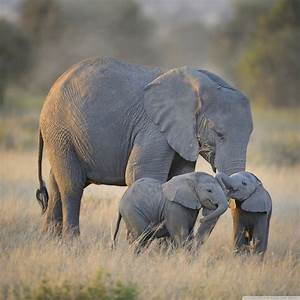

In [53]:
# def test_single_image(path):
#     animals = ['butterflies', 'chickens', 'elephants', 'horses', 'spiders', 'squirells']
#     images = read_image(path)
#     time.sleep(.5)
#     bt_prediction = vgg16.predict(images)  
#     preds = model.predict(bt_prediction)
#     for idx, animal, x in zip(range(0,6), animals , preds[0]):
#         print("ID: {}, Label: {} {}%".format(idx, animal, round(x*100,2) ))
#     print('Final Decision:')
#     time.sleep(.5)
#     for x in range(3):
#         print('.'*(x+1))
#         time.sleep(.2)
#     class_predicted = model.predict(bt_prediction)
#     class_dictionary = generator_top.class_indices  
#     inv_map = {v: k for k, v in class_dictionary.items()}  
#     print("ID: {}, Label: {}".format(class_predicted[0], inv_map[class_predicted[0]]))  
#     return load_img(path)
# path = 'data/test/butterears2.jpg'
# test_single_image(path)
import numpy as np

def test_single_image(path):
    animals = ['butterflies', 'chickens', 'elephants', 'horses', 'spiders', 'squirells']
    images = read_image(path)
    time.sleep(.5)
    bt_prediction = vgg16.predict(images)
    preds = model.predict(bt_prediction)
    for idx, animal, x in zip(range(0, 6), animals, preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, animal, round(x * 100, 2)))
    print('Final Decision:')
    time.sleep(.5)
    for x in range(3):
        print('.' * (x + 1))
        time.sleep(.2)
    class_predicted = model.predict(bt_prediction)
    class_index = np.argmax(class_predicted[0])  # Get the index of the predicted class
    class_dictionary = generator_top.class_indices  
    inv_map = {v: k for k, v in class_dictionary.items()}  
    class_label = inv_map[class_index]  # Get the corresponding label from the dictionary
    print("ID: {}, Label: {}".format(class_index, class_label))
    return load_img(path)

path = 'data/test/elephants/OIP-v9Au4wvcOhj5MSMk421biQHaHa.jpeg'
test_single_image(path)

